In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.graph_objects as go
import statsmodels.api as sm
import math
from collections import defaultdict
from plotly.subplots import make_subplots
from scipy.stats import skew, kstest, skewtest, boxcox, probplot, norm
from scipy.special import inv_boxcox

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


Let's look at the data:

In [2]:
df = pd.read_csv("../input/company-sales/company.csv")
df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


Data shows the sales amount generated for various companies after advertising through three main forms.

In [3]:
df.shape

(200, 4)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [5]:
df.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,15.130500
std,85.854236,14.846809,21.778621,5.283892
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,11.000000
50%,149.750000,22.900000,25.750000,16.000000
75%,218.825000,36.525000,45.100000,19.050000
max,296.400000,49.600000,114.000000,27.000000


Seems like the top advertisement fields (by costs) are:

1. TV
2. Newspapers
3. Radio

And that makes perfect sense.

In [6]:
fig = make_subplots(rows=2, cols=2)

trace0 = go.Histogram(x=df['TV'], name='TV')
trace1 = go.Histogram(x=df['Radio'], name='Radio')
trace2 = go.Histogram(x=df['Newspaper'], name='Newspaper')
trace3 = go.Histogram(x=df['Sales'], name='Sales')

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)
fig.append_trace(trace3, 2, 2)

fig.show()

'Newspaper' looks more like exponential distribution, and other columns are also not exactly normally distributed.

In [7]:
df.corr().style.background_gradient(cmap='coolwarm')

,TV,Radio,Newspaper,Sales
TV,1.000000,0.054809,0.056648,0.901208
Radio,0.054809,1.000000,0.354104,0.349631
Newspaper,0.056648,0.354104,1.000000,0.157960
Sales,0.901208,0.349631,0.157960,1.000000


We can see that spendings on TV advertisment are higly correlated with Sales, so that feature can be the most important. Radio might be the second important feature, but Newspaper influence is questionable.

In [8]:
fig = go.Figure()

for c in df.columns:
        fig.add_trace(go.Box(
            y=df[c], name=c))
        
fig.show()

Boxplot shows two outliers in Newspaper, but this can happen simply because of highly skewed distribution.

# Data preparation

In order to do linear regression analysis and achieve homoscedasticity of residuals we need our data normalized. Best option here is BoxCox transformation. We can take the whole df, because all features have continuous values.

In [9]:
df[df == 0] = 0.1
df_2 = df.copy()

In [10]:
def boxCox(df):
    params = defaultdict()
    for c in df.columns:
        c_transformed, param = boxcox(df[c])
        df[c] = c_transformed
        params[c] = param
    return df, dict(params)

In [11]:
df_transformed, params = boxCox(df_2)

From BoxCox we get transformed df and dict of used alpha params for furhter inverse transformation.

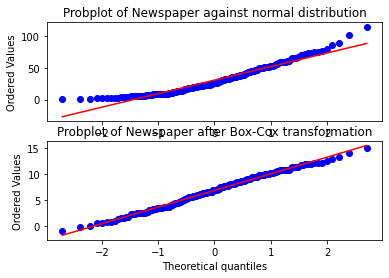

In [12]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
prob = probplot(df['Newspaper'], dist=norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot of Newspaper against normal distribution')

ax2 = fig.add_subplot(212)
prob = probplot(df_transformed['Newspaper'], dist=norm, plot=ax2)
ax2.set_title('Probplot of Newspaper after Box-Cox transformation')

plt.show()

# Regression analysis

Let's use statmodels OLS regression (Ordinary Least Squares) for modeling.

In [13]:
y = df_transformed['Sales']
X = df_transformed[['TV', 'Newspaper', 'Radio']]
X = sm.add_constant(X)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
results = sm.OLS(y_train, X_train).fit()
print(results.summary()) 

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     426.4
Date:                Sun, 16 Jan 2022   Prob (F-statistic):           5.94e-69
Time:                        15:12:09   Log-Likelihood:                -253.29
No. Observations:                 140   AIC:                             514.6
Df Residuals:                     136   BIC:                             526.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6199      0.443      3.654      0.0

The results show that the given model got an F-statistic score of 426.4 compared to the intercept-only model (only bias - const) - it is much higher than F-critical score for degreses of freedom equal to 136 and 3. P-value of F-statistic is very small. It means that we can reject H0 and the independent variables are jointly significant in explaining the variance of the dependent variable - the model have good quality.

R^2 value (90%) is the amount of the variation of Sales which is predictable from the input independent variables.

Null hypotesis of p-value > t: weight values of features are not equal to zero. The Newspaper p-value is 0.160 > 0.05, so we can exclude it.

In [15]:
y = df_transformed['Sales']
X = df_transformed[['TV', 'Radio']]
X = sm.add_constant(X)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
results = sm.OLS(y_train, X_train).fit()
print(results.summary()) 

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     634.0
Date:                Sun, 16 Jan 2022   Prob (F-statistic):           5.61e-70
Time:                        15:12:09   Log-Likelihood:                -254.31
No. Observations:                 140   AIC:                             514.6
Df Residuals:                     137   BIC:                             523.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9423      0.382      5.091      0.0

Now all features are important to a model.

# Residuals analysis

It's time to check residuals distribution and predictions:

In [17]:
y_cox = results.predict(X_test)

Get original value of Sales with alpha-parameter:

In [18]:
y_inv = inv_boxcox(y_cox, params['Sales'])

In [19]:
residuals = y_inv - y_test

In [20]:
import plotly.express as px

fig = px.scatter(residuals, trendline="ols", title='Distribution of residuals')
fig.show()

Seems like residuals are really close to normal distribution, but still we need some testing.

Skewtest tests the null hypothesis that the skewness of the population that the sample was drawn from is the same as that of a corresponding normal distribution.

In [21]:
skewtest(residuals)

SkewtestResult(statistic=1.6564372523191047, pvalue=0.09763330231808955)

With of p-value = 0.09 > 0.05, the skewtest does not reject the hypothesis that the sample (residuals) came from the normal distribution.

Kstest tests the null hypothesis that the two distributions are identical (compares with 'norm' with 0 mean, 1 std; so normalization needed).

In [22]:
residuals_norm = (residuals - residuals.mean())/residuals.std()
kstest(residuals_norm, 'norm')

KstestResult(statistic=0.09157322010374602, pvalue=0.6616093948809076)

With of p-value = 0.66 > 0.05, the K-S test does not reject the hypothesis that the sample came from the normal distribution.

So, we cannot reject the H0 hypothesis that residuals are normally distributed.

# Making predictions

In [23]:
fig = go.Figure()

trace0 = go.Scatter(y=y_test, name='real')
trace1 = go.Scatter(y=y_inv, name='predicted')

fig.add_trace(trace0)
fig.add_trace(trace1)

fig.update_layout(
    title={
        'text': "Sales amount"})
fig.show()

In [24]:
from sklearn.metrics import r2_score

r2_score(y_test, y_inv)

0.768698295969694

And that means model (includes costs of TV and Radio advertisements) explained 76% of variety in Sales amount.

So, our model have met all of four assumptions associated with a linear regression model:

1. Linearity: The relationship between X and the mean of Y is linear.
2. Homoscedasticity: The variance of residual is the same for any value of X.
3. Independence: Observations are independent of each other.
4. Normality: For any fixed value of X, Y is normally distributed.